# Theoretical approach to computational finance:
# option pricing with model calibration, the Greeks, implied volatility 

The project aims at pricing European call and put options on a (continuous) dividend paying stock using 

* the Black-Scholes-Merton (BSM) formula,

* Fast Fourier Transform (FFT) for the BSM, Heston and Variance Gamma models including model calibration with the BSM prices as a reference,

* Monte Carlo simulations.

Calculations of selected Greeks and implied volatility using the Newton-Raphson and Brent methods are also presented.

For the purposes of the current project, option pricing requires model-specific parameters (whose values will be given in the course of calculations), \
as well as the following market-related inputs:  
S0 [USD] - spot price,  
K [USD] - strike price,  
T [years] - time to maturity,  
$\sigma$ [%] - volatility, converted to decimal,  
r [%] - risk-free interest rate, converted to decimal,  
q [%] - dividend rate, converted to decimal.

---------------------------------

Parameter values that can be adjusted to one's computational needs are marked by a set of hashes at the end of an explanation line.

In [3]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize

import matplotlib.pyplot as plt
import pandas as pd

from collections import Counter

import warnings
warnings.filterwarnings('ignore')   # suppress warnings

from IPython.core.magic import register_cell_magic
from IPython import get_ipython
#
@register_cell_magic
def skip_if(line, cell):   # conditionally skip cell execution
    if eval(line):
        return
    get_ipython().run_cell(cell)

In [4]:
# establishing the option type
option_type = input("What is the option type to be priced (call or put)? ")
print(option_type)

What is the option type to be priced (call or put)?  put


put


In [5]:
# auxiliary input market-related parameters #####################################
if option_type == 'call':   # ITM: S0 > K
    S0 = 100
    K = 80
elif option_type == 'put':   # ITM: S0 < K
    S0 = 80
    K = 100
#
T = 1
σ = 0.45
r = 0.05
q = 0.01

### The Black-Scholes-Merton formula for a (continuous) dividend paying stock

The BSM model provides a differential equation relating an option price with an underlying stock price, its volatility, risk-free interest and dividend rates and time to maturity. Its solutions are option prices. A type of an option depends on imposed boundary conditions.

In [8]:
class BSMmodel:
    def __init__(self, S0, K, T, σ, r, q):
        self.S0 = S0
        self.K = K
        self.T = T
        self.σ = σ
        self.r = r
        self.q = q

    # calculating the BSM model variables
    def d1(self):
        return (np.log(self.S0/self.K) + (self.r - self.q + self.σ**2/2) * self.T) / (self.σ * np.sqrt(self.T))
    
    def d2(self):
        return self.d1() - self.σ * np.sqrt(self.T)
    
    # calculating the European option prices
    def call_price(self):
        return (self.S0 * np.exp(-self.q * self.T) * norm.cdf(self.d1()) 
                - self.K * np.exp(-self.r * self.T) * norm.cdf(self.d2()))
    
    def put_price(self):
        return (self.K * np.exp(-self.r * self.T) * norm.cdf(-self.d2()) 
                - self.S0 * np.exp(-self.q * self.T) * norm.cdf(-self.d1()))

In [9]:
# printing the option value
if option_type == 'call':
    option_price = BSMmodel(S0, K, T, σ, r, q).call_price()
elif option_type == 'put':
    option_price = BSMmodel(S0, K, T, σ, r, q).put_price()
else:
    raise ValueError("Option type must be 'call' or 'put'.")

print(f"The price of the European {option_type} option according to the BSM formula is {round(option_price, 2)} USD.")

The price of the European put option according to the BSM formula is 24.72 USD.


### Fast Fourier Transform (FFT) for the Black-Scholes-Merton, Heston and Variance Gamma models

Option payoff is the profit it can earn under different price conditions. The payoff is a function of an underlying stock's price at expiration. Pricing the option requires integrating the payoff against conditional probability distribution function (CPDF) of the stock price at expiration, given today's spot. If the distribution function is known in its closed form, numerical integration can be performed. Otherwise, instead of the CPDF, a characteristics function of the log of the stock price process can be utilized. It is the Fourier transform of the PDF with a reversed sign.  

The following parameters are required for the FFT procedure:  
n - a factor to determine the number of steps,  
$\eta$ - step size for numerical integration,  
$\alpha$ - the Carr-Madan damping constant.

In [12]:
# establishing the model
model = input("What is the pricing model to be used (BSM for Black-Scholes-Merton, Heston, VG for Variance Gamma)? ")
print(model)

What is the pricing model to be used (BSM for Black-Scholes-Merton, Heston, VG for Variance Gamma)?  Heston


Heston


In [13]:
# the model-specific parameter for the BSM and initial guesses for calibration of Heston and Variance Gamma models
parameters = []
parameters.append(σ)

ini_guess = []
#
if (model == 'Heston'):
    κ = 2.5
    θ = 0.025
    ρ = -0.55
    v0 = 0.03
    ini_guess.append(κ)
    ini_guess.append(θ)
    ini_guess.append(σ)
    ini_guess.append(ρ)
    ini_guess.append(v0)
#
elif (model == 'VG'):
    ν = 0.5
    θ = -0.45
    ini_guess.append(σ)
    ini_guess.append(ν)
    ini_guess.append(θ)

In [14]:
# the characteristic function computation
def char_fun(u, parameters, S0, r, q, T, model):
    
    if (model == 'BSM'):
        σ = parameters[0]
        #
        drift = np.log(S0) + (r - q - σ**2/2) * T
        diffusion = σ * np.sqrt(T)
        ϕ = np.exp(1j * drift * u - (diffusion * u)**2/2)
        
    elif (model == 'Heston'):
        κ = parameters[0]
        θ = parameters[1]
        σH = parameters[2]
        ρ = parameters[3]
        v0 = parameters[4]
        #
        aux1 = κ - 1j * ρ * σH * u
        aux2 = κ * θ / σH**2
        γ = np.sqrt(σH**2 * (u**2 + 1j * u) + aux1**2)
        log1 = 1j * u * np.log(S0) + 1j * u * (r - q) * T + aux2 * T * aux1
        log2 = (u**2 + 1j * u) * v0 / (γ * np.tanh(γ * T/2) + aux1)
        den = (np.cosh(γ * T/2) + aux1/γ * np.sinh(γ * T/2))**(2 * aux2)
        #
        ϕ = np.exp(log1 - log2) / den

    elif (model == 'VG'):
        σ = parameters[0]
        ν = parameters[1]
        θ = parameters[2]
        #
        if (ν == 0): # -> BSM model
            drift = np.log(S0) + (r - q - σ**2/2) * T
            diffusion = σ * np.sqrt(T)
            ϕ = np.exp(1j * drift * u - (diffusion * u)**2/2)
        else:
            ϕ = np.exp(1j * u * (np.log(S0) + (r - q) * T)) * (1 - 1j * u * θ * ν + σ**2 * u**2 * ν/2)**(-T/ν)

    return ϕ

In [15]:
# option price computation for various strikes
def FFT(parameters, S0, K, r, q, T, n, η, α, model):
    
    N = 2**n
    λ = 2 * np.pi / (N * η)   # step-size in log strike space
    df = np.exp(-r * T)       # discount factor
    
    #β = np.log(S0) - N * λ/2    # when middle of range corresponds to ATM, K=S0
    β = np.log(K)               # when the first value corresponds to a specific strike K
    
    x = np.zeros(N)   # vector x for m=1,...,N
    νj = np.arange(N) * η
    ψ_νj = np.exp(-1j * β * νj) * (char_fun(νj - (α + 1) * 1j, parameters, S0, r, q, T, model) 
                                   / ((α + 1j * νj) * (α + 1 + 1j * νj)))
    x = η * df * ψ_νj
    x[0] = x[0]/2

    km = np.zeros(N)   # strikes km for m=1,...,N
    km = β + np.arange(N) * λ
     
    y = np.fft.fft(x)
    price = np.zeros(N)   # prices at strikes km
    price = np.exp(-α * km) / np.pi * np.real(y)
    
    return km, price

In [16]:
# FFT parameters #####################################
n_values = [6, 10]
η_values = [0.1, 0.25]

α_ini = [1.01, 1.25, 1.5, 1.75, 2, 5]

if option_type == 'call':
    aux = 1
elif option_type == 'put':
    aux = -1

α_values = [aux * a for a in α_ini] # >0 for call and <0 for put options

In [17]:
def calc_FFT_prices(parameters, S0, K, r, q, T, model, n_values, η_values, α_values):
    
    n_prices = len(n_values) * len(η_values) * len(α_values)
    prices = np.zeros([n_prices, 4]) # columns: n, η, α, price
    
    i = 0
    for n in n_values:
        for η in η_values:
            for α in α_values:
                price = 0 
                k_values, price_values = FFT(parameters, S0, K, r, q, T, n, η, α, model)
                price = price_values[0]
                prices[i] = np.array([n, η, α, round(price,4)])
                i += 1
    
    return prices

---------------------------------

In [19]:
%%skip_if (model == 'BSM')

# calculation of the reference option prices
def calc_ref_prices(option_type, S0, σ, r, q, K_values, T_values):
    
    n_prices = len(K_values) * len(T_values)
    prices = np.zeros([n_prices, 4]) # columns: K, T [years], T [months], price
    
    i = 0
    for K in K_values:
        for T in T_values:
            bsm = BSMmodel(S0, K, T, σ, r, q)
            if option_type == 'call':
                price = bsm.call_price()
            elif option_type == 'put':
                price = bsm.put_price()            
            prices[i] = np.array([K, T, T*12, round(price,2)])
            i += 1
    
    return prices

In [20]:
%%skip_if (model == 'BSM')

# strikes and times to maturity for calculation of the BSM option prices serving as a reference for calibration #####################################
multi = np.linspace(0.5, 1.5, 6)
K_values = [round(S0*m, 2) for m in multi]
T_values = np.linspace(0.5, 1.5, 7)

ref_prices = calc_ref_prices(option_type, S0, σ, r, q, K_values, T_values)
#
df_ref_prices = pd.DataFrame(ref_prices, columns = ['K [USD]', 'T [years]', 'T [months]', 'price'])
df_ref_prices.pivot(index = 'K [USD]', columns = 'T [months]', values = 'price')

T [months],6.0,8.0,10.0,12.0,14.0,16.0,18.0
K [USD],,,,,,,
40.0,0.08,0.19,0.34,0.53,0.72,0.93,1.15
56.0,1.21,1.83,2.43,2.99,3.52,4.01,4.48
72.0,5.50,6.64,7.61,8.46,9.21,9.88,10.49
88.0,13.86,15.02,16.01,16.86,17.61,18.27,18.87
104.0,25.48,26.25,26.95,27.57,28.14,28.64,29.10
120.0,39.11,39.34,39.62,39.90,40.18,40.44,40.68


In [21]:
%%skip_if (model == 'BSM')

# objective function for calibration
def objective_fun(parameters, ref_prices_cal, S0, K_cal, T_cal, r, q, model):
    
    model_prices = []

    for i in range(K_cal.shape[0]):
        prices = calc_FFT_prices(parameters, S0, K_cal[i], r, q, T_cal[i], model, n_values, η_values, α_values)
        model_price = Counter(prices[:,3].flat).most_common(1)[0][0]   # finding the most frequent FFT price
        model_prices.append(model_price)
    
    return np.sum((np.array(model_prices) - ref_prices_cal)**2)

In [22]:
%%skip_if (model == 'BSM')

# calibration of the model parameters
ref_prices_cal = ref_prices[:,3]
K_cal = ref_prices[:,0]
T_cal = ref_prices[:,1]

params_min = minimize(objective_fun, ini_guess, args = (ref_prices_cal, S0, K_cal, T_cal, r, q, model), 
                      method='Nelder-Mead')

# the calibrated model-specific parameters
parameters = []

if (model == 'Heston'):
    κ, θ, σH, ρ, v0  = params_min.x
    print(f"Parameters for the calibrated {model} model: "
          f"κ = {round(κ, 4)}, θ = {round(θ, 4)}, σH = {round(σH, 4)}, ρ = {round(ρ, 4)}, v0 = {round(v0, 4)}.")
    #
    parameters.append(κ)
    parameters.append(θ)
    parameters.append(σH)
    parameters.append(ρ)
    parameters.append(v0)

elif (model == 'VG'):
    σVG, ν, θ  = params_min.x
    print(f"Parameters for the calibrated {model} model: σVG = {round(σVG, 4)}, ν = {round(ν, 4)}, θ = {round(θ, 4)}.")
    #
    parameters.append(σVG)
    parameters.append(ν)
    parameters.append(θ)

Parameters for the calibrated Heston model: κ = 7.5959, θ = 0.1727, σH = -0.1225, ρ = 4.925, v0 = 0.4947.


---------------------------------

In [24]:
def print_FFT_prices(parameters, S0, K, r, q, T, model, n_values, η_values, α_values):
    
    prices = calc_FFT_prices(parameters, S0, K, r, q, T, model, n_values, η_values, α_values)
    n_prices = prices.shape[0]
    
    print("Model: " + model)
    print("N\t η\t α\t price")
    
    for i in range(n_prices):
        print('2^%i\t %.2f\t %.2f\t %.4f' % (prices[i, 0], prices[i, 1], prices[i, 2], prices[i, 3]))
    
    return prices

In [25]:
prices = print_FFT_prices(parameters, S0, K, r, q, T, model, n_values, η_values, α_values)

Model: Heston
N	 η	 α	 price
2^6	 0.10	 -1.01	 133.2060
2^6	 0.10	 -1.25	 24.4250
2^6	 0.10	 -1.50	 24.4227
2^6	 0.10	 -1.75	 24.4201
2^6	 0.10	 -2.00	 24.4175
2^6	 0.10	 -5.00	 24.4168
2^6	 0.25	 -1.01	 357.3268
2^6	 0.25	 -1.25	 24.5939
2^6	 0.25	 -1.50	 24.4162
2^6	 0.25	 -1.75	 24.4159
2^6	 0.25	 -2.00	 24.4159
2^6	 0.25	 -5.00	 24.4159
2^10	 0.10	 -1.01	 133.1955
2^10	 0.10	 -1.25	 24.4159
2^10	 0.10	 -1.50	 24.4159
2^10	 0.10	 -1.75	 24.4159
2^10	 0.10	 -2.00	 24.4159
2^10	 0.10	 -5.00	 24.4159
2^10	 0.25	 -1.01	 357.3268
2^10	 0.25	 -1.25	 24.5939
2^10	 0.25	 -1.50	 24.4162
2^10	 0.25	 -1.75	 24.4159
2^10	 0.25	 -2.00	 24.4159
2^10	 0.25	 -5.00	 24.4159


In [26]:
# finding the most frequent FFT option price
FFTprice = Counter(prices[:,3].flat).most_common(1)

# printing the option value
print(f"The price of the European {option_type} option calculated using the FFT, "
      f"according to the {model} model is {round(FFTprice[0][0], 2)} USD.")

The price of the European put option calculated using the FFT, according to the Heston model is 24.42 USD.


### Monte-Carlo simulations

The Monte-Carlo technique enables pricing complex financial instruments. The first step is to generate a large number of random scenarios for the underlying asset, assuming it follows a geometric Brownian motion. Having the stock price estimates at maturity, the corresponding payoffs are calculated and discounted due to the time value of money. The option price is given as an average of the obtained results.

The following parameters are required for the Monte-Carlo procedure:  
n - number of iterations in a given scenario,  
M - number of simulations.

In [29]:
# Monte-Carlo parameters #####################################
n = 1000
M = 100000

In [30]:
# simulating a single MC path using geometric Brownian motion
def sim_path(S0, σ, r, q, T, n):
    
    dt = T/n
    
    prices = np.zeros(n+1)
    prices[0] = S0
    
    for i in range(1, n+1):
        dW = np.random.normal(0, np.sqrt(dt))
        prices[i] = prices[i-1] * np.exp((r - q - σ**2/2) * dt + σ * dW)
    
    return prices

# calculating the option price
def calc_MC_price(S0, K, T, r, σ, q, option_type, M, n):
    
    paths = np.zeros((M,n+1))
    payoffs = np.zeros(M)
    
    for i in range(M):
        path = sim_path(S0, σ, r, q, T, n)
        
        paths[i,:] = path
        
        # calculating payoff
        if option_type == 'call':
            aux = 1
        elif option_type == 'put':
            aux = -1
        payoff = max(aux * (path[-1] - K), 0)
        
        payoffs[i] = payoff
        
    # calculating the present option price as an average discounted payoff
    price = np.exp(-r * T) * np.mean(payoffs)
    
    return paths, price

In [31]:
MC_paths, MC_price = calc_MC_price(S0, K, T, r, σ, q, option_type, M, n)

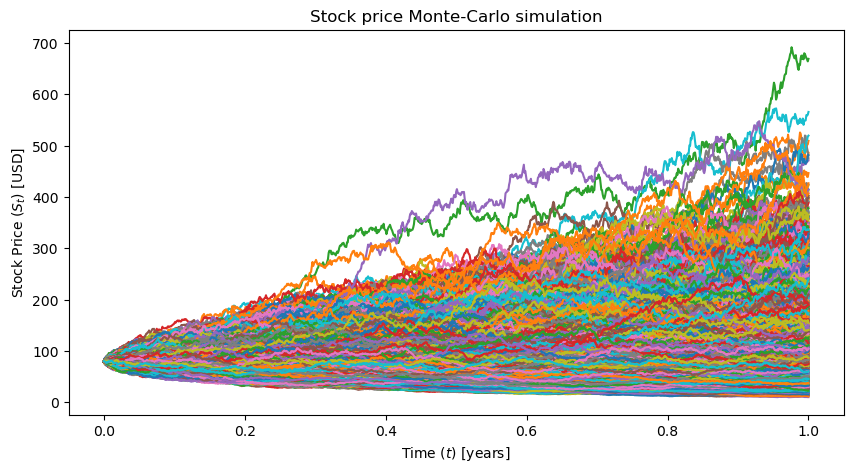

In [32]:
# plotting Monte-Carlo simulations
t_vals = np.linspace(0, T, n+1)   # a vector of t-values
times = np.full(shape=(M,n+1), fill_value=t_vals)

plt.figure(figsize=(10,5))
plt.plot(times.T, MC_paths.T)
plt.xlabel("Time ($t$) [years]")
plt.ylabel("Stock Price ($S_t$) [USD]")
plt.title("Stock price Monte-Carlo simulation")
plt.show()

In [33]:
# printing the option value
print(f"The Monte-Carlo simulated European {option_type} option price is equal to {round(MC_price, 2)} USD.")

The Monte-Carlo simulated European put option price is equal to 24.75 USD.


---------------------------------

In [35]:
print(f"OPTION PRICING SUMMARY")
print(f"Option type: European {option_type}")

print(f"Option price [USD]:\n\
 the BSM model: {round(option_price, 2)}\n\
 the {model} model using the FFT: {round(FFTprice[0][0], 2)}\n\
 the Monte-Carlo simulation: {round(MC_price, 2)}")

OPTION PRICING SUMMARY
Option type: European put
Option price [USD]:
 the BSM model: 24.72
 the Heston model using the FFT: 24.42
 the Monte-Carlo simulation: 24.75


### The Greeks for the BSM model

The Greeks quantify various aspects of the risk in an option position. Selected Greeks measure sensitivity of an option price to the following factors:  
Delta - the price of the underlying asset (first derivative),  
Gamma - the price of the underlying asset (second derivative),  
Theta - time,  
Vega - volatility of an underlying asset,  
Rho - interest rate,  
Epsilon - underlying dividend yield,  
Charm - the price and volatility of the underlying asset,  
Vanna - the price of the underlying asset and time,  
Vomma - volatility of the underlying asset (second derivative).

In [38]:
class Greeks(BSMmodel):
    def Delta_call(self):
        return np.exp(-self.q * self.T) * norm.cdf(self.d1())

    def Delta_put(self):
        return -np.exp(-self.q * self.T) * norm.cdf(-self.d1())
    
    def Gamma(self):
        return np.exp(-self.q * self.T) * norm.pdf(self.d1()) / (self.S0 * self.σ * np.sqrt(self.T))
        #return self.K * np.exp(-self.r * self.T) * norm.pdf(self.d2()) / (self.S0**2 * self.σ * np.sqrt(self.T))

    def Theta_call(self):
        return (-np.exp(-self.q * self.T) * self.S0 * norm.pdf(self.d1()) * self.σ / (2 * np.sqrt(self.T)) 
                - self.r * self.K * np.exp(-self.r * self.T) * norm.cdf(self.d2()) 
                + self.q * self.S0 * np.exp(-self.q * self.T) * norm.cdf(self.d1()))
    
    def Theta_put(self):
        return (-np.exp(-self.q * self.T) * self.S0 * norm.pdf(self.d1()) * self.σ / (2 * np.sqrt(self.T)) 
                + self.r * self.K * np.exp(-self.r * self.T) * norm.cdf(-self.d2()) 
                - self.q * self.S0 * np.exp(-self.q * self.T) * norm.cdf(-self.d1()))

    def Vega(self):
        return self.S0 * np.exp(-self.q * self.T) * norm.pdf(self.d1()) * np.sqrt(self.T)
        #return self.K * np.exp(-self.r * self.T) * norm.pdf(self.d2()) * np.sqrt(self.T)
    
    def Rho_call(self):
        return self.K * self.T * np.exp(-self.r * self.T) * norm.cdf(self.d2())
    
    def Rho_put(self):
        return -self.K * self.T * np.exp(-self.r * self.T) * norm.cdf(-self.d2())
    
    def Epsilon_call(self):
        return -self.S0 * self.T * np.exp(-self.q * self.T) * norm.cdf(self.d1())
    
    def Epsilon_put(self):
        return self.S0 * self.T * np.exp(-self.q * self.T) * norm.cdf(-self.d1())
    
    def Vanna(self):
        return np.exp(-self.q * self.T) * norm.pdf(self.d1()) * self.d2()/self.σ
    
    def Charm_call(self):
        return (self.q * np.exp(-self.q * self.T) * norm.cdf(self.d1()) 
                - np.exp(-self.q * self.T) * norm.pdf(self.d1()) * ((self.r - self.q) / (self.σ * np.sqrt(self.T)) 
                                                                    - self.d2()/(2 * self.T)))
    
    def Charm_put(self):
        return (-self.q * np.exp(-self.q * self.T) * norm.cdf(-self.d1()) 
                - np.exp(-self.q * self.T) * norm.pdf(self.d1()) * ((self.r - self.q)/(self.σ * np.sqrt(self.T)) 
                                                                    - self.d2()/(2 * self.T)))
    
    def Vomma(self):
        return self.S0 * np.exp(-self.q * self.T) * norm.pdf(self.d1()) * np.sqrt(self.T) * self.d1() * self.d2()/self.σ

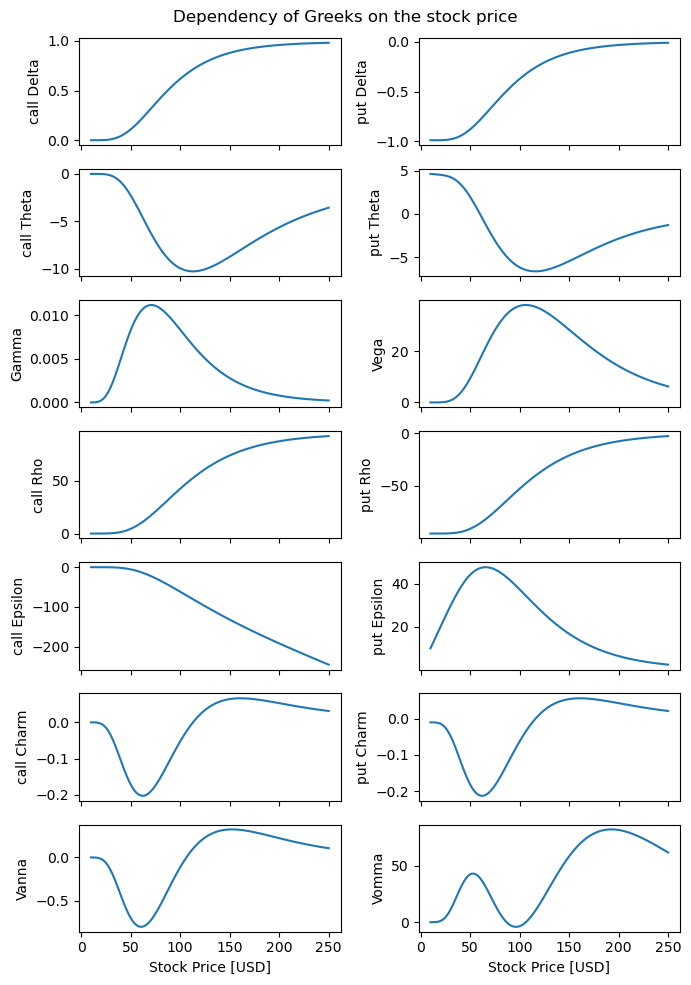

In [39]:
# dependence of the Greeks on stock price
stock_prices = np.linspace(10, 250, 100)   # range of stock prices

call_deltas = Greeks(stock_prices, K, T, σ, r, q).Delta_call()
put_deltas = Greeks(stock_prices, K, T, σ, r, q).Delta_put()
call_thetas = Greeks(stock_prices, K, T, σ, r, q).Theta_call()
put_thetas = Greeks(stock_prices, K, T, σ, r, q).Theta_put()
gammas = Greeks(stock_prices, K, T, σ, r, q).Gamma()
vegas = Greeks(stock_prices, K, T, σ, r, q).Vega()
call_rhos = Greeks(stock_prices, K, T, σ, r, q).Rho_call()
put_rhos = Greeks(stock_prices, K, T, σ, r, q).Rho_put()
call_epsilons = Greeks(stock_prices, K, T, σ, r, q).Epsilon_call()
put_epsilons = Greeks(stock_prices, K, T, σ, r, q).Epsilon_put()
call_charms = Greeks(stock_prices, K, T, σ, r, q).Charm_call()
put_charms = Greeks(stock_prices, K, T, σ, r, q).Charm_put()
vannas = Greeks(stock_prices, K, T, σ, r, q).Vanna()
vommas = Greeks(stock_prices, K, T, σ, r, q).Vomma()

fig, axs = plt.subplots(7, 2, figsize=(7, 10), sharex=True)
axs[0,0].plot(stock_prices, call_deltas)
axs[0,0].set(ylabel="call Delta")
axs[0,1].plot(stock_prices, put_deltas)
axs[0,1].set(ylabel="put Delta")
axs[1,0].plot(stock_prices, call_thetas)
axs[1,0].set(ylabel="call Theta")
axs[1,1].plot(stock_prices, put_thetas)
axs[1,1].set(ylabel="put Theta")
axs[2,0].plot(stock_prices, gammas)
axs[2,0].set(ylabel="Gamma")
axs[2,1].plot(stock_prices, vegas)
axs[2,1].set(ylabel="Vega")
axs[3,0].plot(stock_prices, call_rhos)
axs[3,0].set(ylabel="call Rho")
axs[3,1].plot(stock_prices, put_rhos)
axs[3,1].set(ylabel="put Rho")
axs[4,0].plot(stock_prices, call_epsilons)
axs[4,0].set(ylabel="call Epsilon")
axs[4,1].plot(stock_prices, put_epsilons)
axs[4,1].set(ylabel="put Epsilon")
axs[5,0].plot(stock_prices, call_charms)
axs[5,0].set(ylabel="call Charm")
axs[5,1].plot(stock_prices, put_charms)
axs[5,1].set(ylabel="put Charm")
axs[6,0].plot(stock_prices, vannas)
axs[6,0].set(ylabel="Vanna")
axs[6,1].plot(stock_prices, vommas)
axs[6,1].set(ylabel="Vomma")
axs[6,0].set(xlabel="Stock Price [USD]")
axs[6,1].set(xlabel="Stock Price [USD]")

fig.suptitle("Dependency of Greeks on the stock price")
fig.tight_layout()

### Implied volatility

Volatility of a stock is a measure of uncertainty about returns provided by the stock. It can be calculated in either backward- or forward-looking manner. The latter provides volatility implied by option prices observed in the market.  
The idea behind the implied volatility calculation is the following. It is assumed that the market price of an option, $P_0$, is equal to its price calculated within a theoretical model, $P_m$. The latter is parametrized by a set of variables, one of which is volatility of an underlying stock. Solving the equation $P_0 = P_m(\sigma, ...)$ for $\sigma$ gives the implied volatility value. In practice, an analytical solution to the equation does not exist and the issue is reduced to the problem of finding a root of the equation $P_0 - P_m = 0$ with $\sigma$ as an independent variable.

Calculating implied volatility employs a root-finding numerical iterative model. Apart from the market value of the option, P0, setting up the numerical scheme requires imposing the following parameters:  
prec - precision of the determined implied volatility,  
max_iter - maximum number of iterations.

In [42]:
# parameters for the iv calculation #####################################
prec = 1.0e-5
max_iter = 100
#
σ_min = 0.1   # interval containing iv
σ_max = 0.9
#
P0 = 25   # current market option price, auxiliary

In [43]:
# calculating implied volatility using the Newton-Raphson method
iv = P0/S0 * np.sqrt(2*np.pi / T)   # iv initial guess

def calc_imp_vol_NR(option_type, P0, S0, K, T, iv, r, q, prec, max_iter):

    for i in range(max_iter):
        bsm = BSMmodel(S0, K, T, iv, r, q)
        
        if option_type == 'call':
            diff = bsm.call_price() - P0
        elif option_type == 'put':
            diff = bsm.put_price() - P0
        
        Vega = Greeks(S0, K, T, iv, r, q).Vega()
        
        if (abs(diff) < prec):
            return iv
        
        iv = iv - diff/Vega
        
    return iv   # if prec was not achieved, return the closest value obtained

In [44]:
# printing value of the implied volatility
print(f"Implied volatility calculated with the Newton-Raphson method for the European {option_type} option "
      f"is equal to {round(calc_imp_vol_NR(option_type, P0, S0, K, T, iv, r, q, prec, max_iter), 7)}.")

Implied volatility calculated with the Newton-Raphson method for the European put option is equal to 0.4590493.


In [45]:
# calculating implied volatility using the Brent's method
from scipy.optimize import brentq

def calc_imp_vol_B(option_type, P0, S0, K, T, r, q, σ_min, σ_max, prec, max_iter):
    
    def price_diff(iv):
        bsm = BSMmodel(S0, K, T, iv, r, q)
        
        if option_type == 'call':
            diff = bsm.call_price() - P0
        elif option_type == 'put':
            diff = bsm.put_price() - P0
        
        return diff
    
    return brentq(price_diff, a=σ_min, b=σ_max, xtol=prec, maxiter=max_iter)

In [46]:
# printing value of the implied volatility
print(f"Implied volatility calculated with the Brent's method for the European {option_type} option "
      f"is equal to {round(calc_imp_vol_B(option_type, P0, S0, K, T, r, q, σ_min, σ_max, prec, max_iter), 7)}.")

Implied volatility calculated with the Brent's method for the European put option is equal to 0.4590493.


---------------------------------

In [48]:
print(f"IV BSM CALCULATION SUMMARY")
print(f"Option type: European {option_type}")

print(f"Implied volatility:\n\
 the Newton-Raphson method: {round(calc_imp_vol_NR(option_type, P0, S0, K, T, iv, r, q, prec, max_iter)*100, 5)}%\n\
 the Brent's method: {round(calc_imp_vol_B(option_type, P0, S0, K, T, r, q, σ_min, σ_max, prec, max_iter)*100, 5)}%")

IV BSM CALCULATION SUMMARY
Option type: European put
Implied volatility:
 the Newton-Raphson method: 45.90493%
 the Brent's method: 45.90493%


###### Anna Nakonieczna, Jan 2025